In [21]:
# Librerías generales

import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd 

### Lectura de datos

In [2]:
import os
import numpy as np
import pickle

# Define la carpeta de datos (ajusta esto según el nombre que reciban los datos en Kaggle)
data_folder_name = '../input/dataselected'  

# Definir una función para obtener los nombres de archivos en una carpeta
def getFileNames(folder_name):
    file_names = os.listdir(folder_name)
    return file_names

print(getFileNames(data_folder_name))

# Lectura de archivos '.npy'
x_test = np.load(f'{data_folder_name}/x_sub_val.npy')
x_train = np.load(f'{data_folder_name}/x_sub_train_aug.npy')

y_train_coarse = np.load(f'{data_folder_name}/y_sub_train_aug_1.npy')
y_train_fine = np.load(f'{data_folder_name}/y_sub_train_aug_0.npy')

y_test_coarse = np.load(f'{data_folder_name}/y_sub_val_1.npy')
y_test_fine = np.load(f'{data_folder_name}/y_sub_val_0.npy')

# Lectura de archivos '.pck'
with open('/kaggle/input/dl-itba-cifar-100-2024-q-1/coarse_label_names.pck', "rb") as f:
    coarse_label_names = pickle.load(f)

with open('/kaggle/input/dl-itba-cifar-100-2024-q-1/fine_label_names.pck', "rb") as f:
    fine_label_names = pickle.load(f)

# Información de las dimensiones de los datos
print('Dimensiones de los datos:')
print(x_test.shape)
print(x_train.shape)
print(y_train_coarse.shape)
print(y_train_fine.shape)

print('Cantidad de clases:')
print(np.shape(coarse_label_names))
print(np.shape(fine_label_names))


['x_sub_val.npy', 'y_sub_train_aug_0.npy', 'y_sub_train_aug_1.npy', 'y_sub_val_1.npy', 'x_sub_train_aug.npy', 'y_sub_val_0.npy']
Dimensiones de los datos:
(10000, 32, 32, 3)
(1040000, 32, 32, 3)
(1040000,)
(1040000,)
Cantidad de clases:
(20,)
(100,)


In [3]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Flatten, LayerNormalization,BatchNormalization, Conv2D, MaxPooling2D
from keras.models import Model
from keras.regularizers import l2

## CALLBACKS


In [6]:
#OTRA ESTRUCTURA
# Entrada y normalización
input_layer = Input(shape=(32, 32, 3), name="matrix_input")

# Estructura de la red
x = BatchNormalization(axis=-1, name="normalization_layer")(input_layer)
flatten_layer = Flatten(name="flattened_input")(x)

# Capas densas y Dropout adicionales para mayor capacidad
dense_2048 = Dense(2048, activation='relu', name="dense_2048")(flatten_layer)
dropout_2048 = Dropout(0.4)(dense_2048)

dense_1024 = Dense(1024, activation='relu', name="dense_1024")(dropout_2048)
dropout_1024 = Dropout(0.3)(dense_1024)

# Capas intermedias adicionales
dense_512_a = Dense(512, activation='relu', name="dense_512_a")(dropout_1024)
dropout_512_a = Dropout(0.2)(dense_512_a)


# Continuación de las capas existentes
dense_512 = Dense(512, activation='relu', name="dense_512")(dropout_512_a)
dropout_512 = Dropout(0.2)(dense_512)

dense_256 = Dense(256, activation='relu', name="dense_256")(dropout_512)
dropout_256 = Dropout(0.2)(dense_256)

dense_128 = Dense(128, activation='relu', name="dense_128")(dropout_256)

# Capas adicionales para mayor profundidad
dense_128_b = Dense(128, activation='relu', name="dense_128_b")(dense_128)
dense_100 = Dense(100, activation='relu', name="dense_100")(dense_128_b)
batch_norm_100 = BatchNormalization()(dense_100)

# Salida
fine_output = Dense(100, activation='softmax', name='fine_output')(batch_norm_100)

# Coarse-grain prediction branch (20 classes)
coarse_output = Dense(20,
                             activation='softmax',
                             name='coarse_output')(dropout_512)

# Defino el modelo con dos salidas
myModel2 = Model(
    inputs                  = input_layer,
    outputs                 = [fine_output]
)


myModel2.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ matrix_input (InputLayer)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_layer             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattened_input (Flatten)       │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2048 (Dense)              │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1024 (Dense)              │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512_a (Dense)             │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128_b (Dense)             │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fine_output (Dense)             │ (None, 100)            │        10,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,383,284 (35.79 MB)

 Trainable params: 9,383,078 (35.79 MB)

 Non-trainable params: 206 (824.00 B)

In [11]:
# Shuffle de los datos
indexes_train   = np.arange(len(x_train))
indexes_test    = np.arange(len(x_test))

np.random.shuffle(indexes_train)
np.random.shuffle(indexes_test)

# Shuffle de datos de train

x_train_dup         = x_train[indexes_train]
y_train_coarse_dup  = y_train_coarse[indexes_train]
y_train_fine_dup    = y_train_fine[indexes_train]

# Shuffle de datos de test
x_test_dup         = x_test[indexes_test]
y_test_coarse_dup  = y_test_coarse[indexes_test]
y_test_fine_dup    = y_test_fine[indexes_test]

### CALLBACKS

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [9]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 5,
    verbose = 1,
    min_lr = 1e-7
)


rlrop2 = ReduceLROnPlateau(
    monitor = "accuracy",
    factor = 0.2,
    patience = 5,
    verbose = 1,
    min_lr = 1e-6
)

es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 8,
    verbose = 1,
    restore_best_weights = True
)

es2 = EarlyStopping(
    monitor = "accuracy",
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

mc2 = ModelCheckpoint(
    "best_weights_v1.weights.h5",
    monitor = "accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,

)


mc = ModelCheckpoint(
    "best_weights_v2.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,

)


### COMPILE

In [12]:
myModel2.compile(
    optimizer               = Adam(learning_rate=0.0001),
    #loss                    = {'fine_output': 'sparse_categorical_crossentropy', 'coarse_output': 'sparse_categorical_crossentropy'},
    loss                    = {'fine_output': 'sparse_categorical_crossentropy'},
    loss_weights            = None,
    #metrics                 = {'fine_output': 'categorical_accuracy', 'coarse_output': 'categorical_accuracy'},
    metrics                 = {'fine_output': 'accuracy'},
    weighted_metrics        = None,
    run_eagerly             = False,
    steps_per_execution     = 1,
    jit_compile             = "auto",
    auto_scale_loss         = True,
)

## MODEL FIT

In [13]:
history2 = myModel2.fit(
    x                       = x_train_dup,
    y                       = {'fine_output': y_train_fine_dup},
    batch_size              = 512,
    epochs                  = 100,
    verbose                 = "auto",
    callbacks               = [LambdaCallback(on_epoch_end=lambda epoch, logs: print(logs if logs is not None else "No logs available")),rlrop,es,mc2,mc],
    validation_split        = 0.0,
    validation_data         = (x_test_dup, {'fine_output': y_test_fine_dup}),
    shuffle                 = True,
    class_weight            = None,
    sample_weight           = None,
    initial_epoch           = 0,
    steps_per_epoch         = None,
    validation_steps        = None,
    validation_batch_size   = None,
    validation_freq         = 1,
)

Epoch 1/100


I0000 00:00:1730163721.341705     102 service.cc:145] XLA service 0x79e6080021d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730163721.341756     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730163721.341761     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  10/2032 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.0069 - loss: 4.9349

I0000 00:00:1730163731.251394     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2032/2032 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0337 - loss: 4.4880{'accuracy': 0.05178653821349144, 'loss': 4.297489166259766, 'val_accuracy': 0.10090000182390213, 'val_loss': 3.915030002593994}

Epoch 1: accuracy improved from -inf to 0.05179, saving model to best_weights_v1.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.10090, saving model to best_weights_v2.weights.h5
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 45s 16ms/step - accuracy: 0.0338 - loss: 4.4879 - val_accuracy: 0.1009 - val_loss: 3.9150 - learning_rate: 1.0000e-04
Epoch 2/100
2031/2032 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0856 - loss: 4.0216{'accuracy': 0.09159326553344727, 'loss': 3.976897954940796, 'val_accuracy': 0.1370999962091446, 'val_loss': 3.692094087600708}

Epoch 2: accuracy improved from 0.05179 to 0.09159, saving model to best_weights_v1.weights.h5

Epoch 2: val_accuracy improved from 0.10090 to 0.13710, saving model to best_weights_v2.weights.h5
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/st

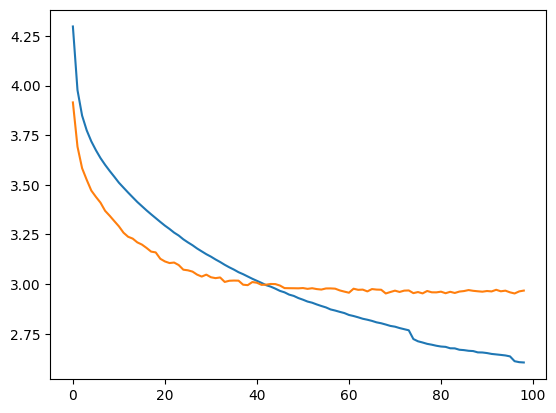

In [16]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])

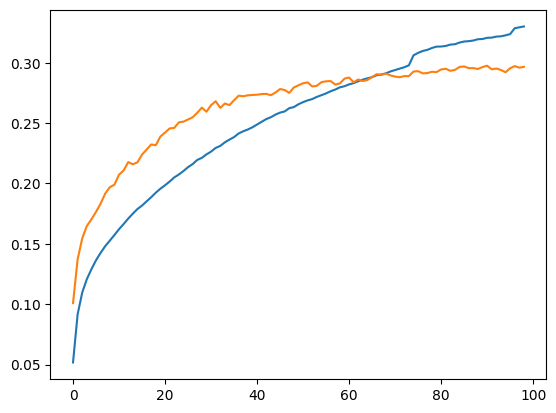

In [17]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])

In [19]:
predictions = myModel2.predict(x_test).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [23]:
df = pd.DataFrame(predictions, columns=["Label"])

In [24]:
df

,Label
0,45
1,79
2,99
3,71
4,58
...,...
9995,20
9996,51
9997,66
9998,0


In [ ]:
df.index.name = "Id"